### TP 2 VISIÓN POR COMPUTADORA.

Integrantes: 

- Lara Rosenberg
- Victoria Terán
- Fernando Vasconcelos



# Objetivo
### Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [16]:
# Importamos las librerias necesarias
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib
import pandas as pd
import math
from typing import List


In [2]:
# Ruta del video
video_path = 'video/focus_video.mov'

#### Definimos funciones auxiliares

In [36]:
# Definimos una clase para el manejo de la región de interes
class Roi:
    
    # Define tamaño de la ROI en función a los parametros de entrada (Porcentaje del frame o ancho y alto de la roi)
    def __init__(self, frame_height: int, frame_width: int, roi: float = 1, height: int = 1, width: int = 1) -> None:
        if roi > 1 or roi <= 0:
            raise ValueError('roi is out of range')

        self.roi = roi
        self.frame_height = frame_height
        self.frame_width = frame_width

        if roi == 1:
            if height > frame_height or width > frame_width:
                raise ValueError('Height/width of the image must be less than the frame height/width')
            self.height = height
            self.width = width
        else:
            # Guardamos el ancho y largo del roi 
            self.height = int(frame_height * math.sqrt(self.roi))
            self.width = int(frame_width * math.sqrt(self.roi))
          
            
        self.y_start = (frame_height - self.height) // 2
        self.y_end = self.y_start + self.height
        self.x_start = (frame_width - self.width) // 2
        self.x_end = self.x_start + self.width
        
    # Devuelve la ROI del frame 
    def apply(self, image: np.array) -> np.array:
        return image[self.y_start:self.y_start + self.height, self.x_start:self.x_start + self.width]

    # Devuelve el rectangulo de la roi
    def get_rectangle(self):
        overlay = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)
        
        return cv2.rectangle(overlay, (self.x_start, self.y_start), (self.x_end, self.y_end), (0, 255, 0), 2)

In [37]:
class Matrix:
    def __init__(self, frame_height: int, frame_width: int, height: int, width: int, nrows: int = 3, ncols: int = 3) -> None:
        if height > frame_height or width > frame_width:
            raise ValueError('Height/width of the image must be less than the frame height/width')
        self._frame_height = frame_height
        self._frame_width = frame_width
        self._height = height
        self._width = width
        
        self.y_start = (frame_height - self._height) // 2
        self.y_end = self.y_start + self._height
        self.x_start = (frame_width - self._width) // 2
        self.x_end = self.x_start + self._width
        
        self._nrows = nrows
        self._ncols = ncols
        # Calcular el tamaño de cada rectángulo
        self._rect_width = self._width // (2 * ncols - 1)
        self._rect_height = self._height // (2 * nrows - 1)
        
        # Para que los rectangulos esten equidistantes calculamos el margen minimo y ajustamos el lado 
        if self._rect_width < self._rect_height:
            self._margin = self._rect_width
            self._rect_height = (self._height - self._margin * (self._nrows - 1)) // self._nrows
        else:
            self._margin = self._rect_height
            self._rect_width = (self._width - self._margin * (self._ncols - 1)) // self._ncols
        
        # Creamos los rectangulos y almacenamos las coordenadas en una lista de tupllas
        self._box_list = list()
        for i in range(nrows):
            for j in range(ncols):
                # Calcular las coordenadas del rectángulo
                x_start = self.x_start + j * (self._rect_width + self._margin)
                y_start = self.y_start + i * (self._rect_height + self._margin)

                x_end = x_start + self._rect_width
                y_end = y_start + self._rect_height
                
                self._box_list.append((x_start, y_start, x_end, y_end))
    
    def apply(self, image: np.array) -> np.array:
        frame_box_list = list()
        for box in self._box_list:
            x_start, y_start, x_end, y_end = box
            frame_box_list.append(image[y_start:y_end, x_start:x_end])
        return frame_box_list
    
    def get_focus_matrix(self) -> np.array:
        overlay = np.zeros((self._frame_height, self._frame_width, 3), dtype=np.uint8)
        for box in self._box_list:
            x_start, y_start, x_end, y_end = box
            cv2.rectangle(overlay, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)
        return overlay
                
        

In [44]:
# Definimos una clase para el manejo de la visualización del video 
class VideoPlayer:
    # Inicializamos la lectura del video y parametros
    def __init__(self, file: str) -> None:
        self.video = cv2.VideoCapture(video_path)
        if not self.video.isOpened():
            raise IOError('Video\'s not opened')
        self._frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self._fps = int(self.video.get(cv2.CAP_PROP_FPS))

        self._roi = None
        self._is_roi_set = False
        self._matrix = None
        self._is_matrix_set = False
        self._matrix_row = 3
        self._matrix_col = 3
        self._current_frame = None
        self._show_roi = False

    # Creamos una ROI (si ya existe se elimina y se vuelve a crear)
    def set_roi(self, roi: float = 1, height: int = 1, width: int = 1, show_roi: bool = False, nrows: int = 3,
                ncols: int = 3) -> None:
        self.unset_matrix()
        # Si hay una roi la elimino
        self.unset_roi()
        self._roi = Roi(self._frame_height, self._frame_width, roi=roi, height=height, width=width)
        self._is_roi_set = True
        self._show_roi = show_roi 
    

    # Eliminamos la ROI si ya existe
    def unset_roi(self):
        if self._is_roi_set and self._roi:
            del self._roi
            self._is_roi_set = False

    @property
    def is_roi_set(self):
        return self._is_roi_set
    
    # Devuelve la ROI del frame si existe. De no existir, devuelve el frame completo
    def get_roi_frame(self) -> np.array:
        if not self._is_roi_set:
            return cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY)
        return self._roi.apply(cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY))

    def set_matrix(self, height: int, width: int, show_matrix: bool = True, nrows: int = 3, ncols: int = 3) -> None:
        self.unset_roi()
        self.unset_matrix()
        self._matrix = Matrix(self._frame_height, self._frame_width, height, width, nrows, ncols)
        self._is_matrix_set = True
        
    # Eliminamos la Matriz si ya existe
    def unset_matrix(self):
        if self._is_matrix_set and self._matrix:
            del self._matrix
            self._is_matrix_set = False
    
    @property
    def is_matrix_set(self):
        return self._is_matrix_set
    
    def get_matrix_frames(self) -> List[np.array]:
        if not self._is_matrix_set:
            return cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY)
        return self._matrix.apply(cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY))
        
    @property
    def shape(self):
        return self._frame_height, self._frame_width

    @property
    def fps(self):
        return self._fps

    @fps.setter
    def fps(self, value):
        self._fps = value

    @property
    def frame_count(self):
        return self._frame_count

    @frame_count.setter
    def frame_count(self, value):
        self._frame_count = value

    # Devuelve el frame. En caso de existir matriz de enfoque se la agrega
    def get_frame(self) -> np.array:    
        ret, self._current_frame = self.video.read()
        if not ret:
            return None

        if self._is_roi_set and self._show_roi:
            roi_rectangle = self._roi.get_rectangle()
            return cv2.bitwise_or(roi_rectangle, self._current_frame)
        elif self._is_matrix_set and self._is_matrix_set:
            focus_matrix = self._matrix.get_focus_matrix()
            return cv2.bitwise_or(focus_matrix, self._current_frame)


        return self._current_frame

    # Devuelve el frame de un indice determinado
    def get_frame_by_index(self, index: int) -> np.array:
        self.set_video_pos(index)
        return self.get_frame()

    # Reinicia el video
    def restart(self):
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Mueve el puntero al indice determinado
    def set_video_pos(self, frame_index):
        if frame_index < 1 or frame_index > self._frame_count:
            raise ValueError('Frame index out of range')
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_index-1)

    # Devuelve la posición del frame actual
    def get_video_pos(self):
        return self.video.get(cv2.CAP_PROP_POS_FRAMES)

    # Libera el video
    def release(self):
        self.video.release()

In [45]:
# Calculamos scatter plot de la metrica de enfoque y lo convertimos en image para agregarlo al video
def convert_to_img(value_list: list, image_shape: tuple, total_frames: int):
    fig, ax = plt.subplots(figsize=(image_shape[1] / 100, image_shape[0] / 100))
    ax.set_xlim(0, total_frames + total_frames * 0.1)
    ax.scatter(range(len(value_list)), value_list)
    ax.set_xlabel('Número de Frame', labelpad=1)
    ax.set_ylabel('IQM')
    ax.set_title('Evolución IQM por Frame', fontsize=10)
    ax.grid(True)

    # Convertimos el gráfico en un array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plt.close(fig)
    width, height = canvas.get_width_height()
    # Convertimos a un array de NumPy 
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape((height, width, 4))

    # Eliminamos el canal alpha y devolvemos
    return image[:, :, :3]

In [46]:
# def graficar(x, y, x_label="Numero de frame", y_label="Metrica"):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(x, y, color='brown', marker='o')
#     # Etiquetas y título
#     plt.xlabel(x_label)
#     plt.ylabel(f'{y_label}')
#     plt.title(f'Evolución {y_label} por Frame')
#     max_value = max(y)
#     max_index = x[y.index(max_value)]
#     plt.scatter(max_index, max_value, color='red', label='Máximo valor')
#     plt.annotate(f'Frame {max_index}\n Máx: {max_value}', xy=(max_index, max_value), xytext=(max_index + 10, max_value - 0.002),
#                  arrowprops=dict(facecolor='black', arrowstyle='->'))
#     plt.grid(True)
#     plt.show()
    
# Grafica el scatter plot recibiendo como entrada las metricas de enfoque y muestra el frame de maximo enfoque 
def graficar_con_frame(x, y, x_label="Numero de frame", y_label="Metrica", frame_image=None):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    # Hacemos el scatter plot
    plt.scatter(x, y, color='brown', marker='o')
    plt.xlabel(x_label)
    plt.ylabel(f'{y_label}')
    plt.title(f'Evolución {y_label} por Frame')
    # Mostramos el valor del frame de maximo enfoque en el scatter plot
    max_value = max(y)
    max_index = x[y.index(max_value)]
    plt.scatter(max_index, max_value, color='red', label='Máximo valor')
    plt.annotate(f'Frame {max_index}\n Máx: {max_value}', xy=(max_index, max_value), xytext=(max_index + 10, max_value - 0.002),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.grid(True)
    
    # Mostramos el frame de maximo enfoque
    plt.subplot(1, 2, 2)
    plt.imshow(frame_image)
    plt.grid(False)
    plt.axis('off')
    
    plt.show()

In [47]:
# Inicilaizamos el video
video_player = VideoPlayer(video_path)

## Implementamos algoritmos y realizamos experimentos:


#### Implementamos el algoritmo IQM

In [48]:
def calcular_iqm(image):
    # Paso 1: Calcular la transformada de Fourier
    F = np.fft.fft2(image)

    # Paso 2: Llevar la baja frecuencia al origen
    FC = np.fft.fftshift(F)

    # Paso 3: Calcular el módulo de la transformada
    AF = np.abs(FC)

    # Paso 4: Calcular el umbral (puedes ajustar este valor)
    umbral = np.max(AF) / 1000

    # Paso 5: Contar los píxeles que superan el umbral
    supera_tresh = np.sum(AF > umbral)

    # Medida de calidad de imagen
    M, N = image.shape
    iqm = supera_tresh / (M * N)
    return iqm

#### Implementamos la metrica de enfoque ACM que esta en el apendice de: Analysis of focus measure operators in shape from focus. 

In [49]:
def calcular_acm(image):
    #Calculamos la media de los pixeles de la imagen
    mean = np.mean(image)
    # Calculamos el histograma para tener la frecuencia de cada pixel
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    # Calculamos la frecuencia del pixel respecto a la frecuencia total de todos los pixeles
    histogram = histogram / histogram.sum() 
    # Calculamos la métrica acm
    acm = np.sum(np.abs(np.arange(256) - mean) * histogram)  
    return acm

#### Experimento 1. Medición sobre todo el frame.

In [50]:
def procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM'):
    video_player.restart()
    metric_lista = []

    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos        
        # Calculamos la metrica
        metric_lista.append(metric(video_player.get_roi_frame()))

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1

    frame_indices = list(range(1, video_player.frame_count + 1))
    max_frame = video_player.get_frame_by_index(max_metric_frame)
    # Graficar los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

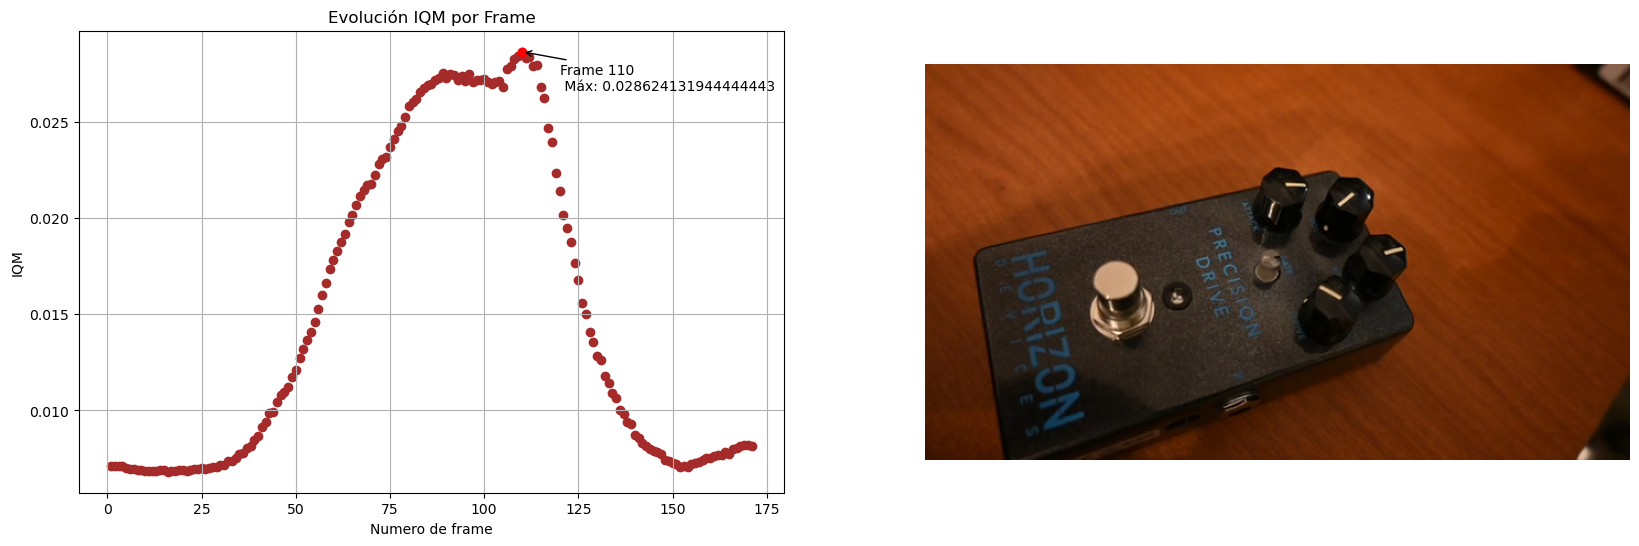

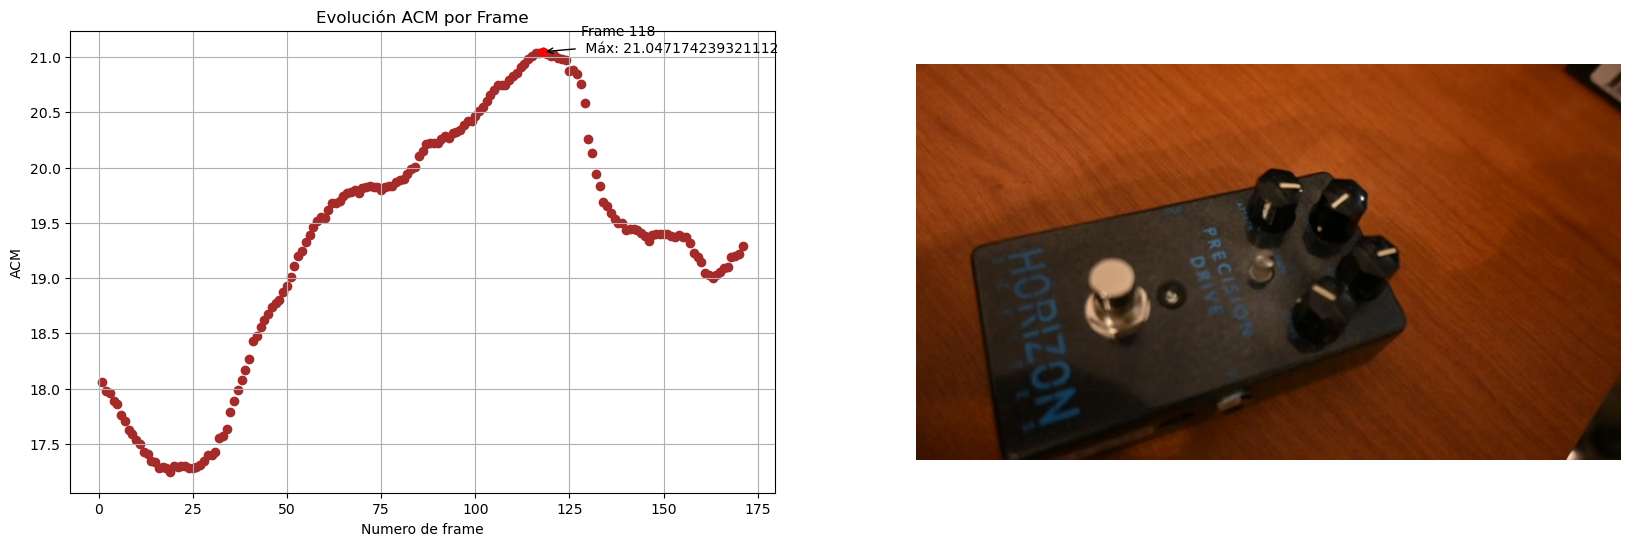

In [51]:
iqm_full_frame_list = procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
acm_full_frame_list = procesar_video_completo(video_player, metric=calcular_acm, name_metric='ACM')

#### Observación: Nos llama la atención que con la metrica ACM se obtiene un valor maximo en un frame que a la vista se ve desenfocado.

#### Experimeto 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

In [52]:
def procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=0.05):
    video_player.unset_roi()
    video_player.restart()
    metric_lista = []

    # Calculamos la roi en función del parametro de entrada roi_number
    # video_player.set_roi(roi=roi_number)
    video_player.set_roi(roi=roi_number, show_roi=True)
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos        
        # Calculamos la metrica
        metric_lista.append(metric(video_player.get_roi_frame()))
    video_player.unset_roi()
    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    
    max_frame = video_player.get_frame_by_index(max_metric_frame)

    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficamos los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

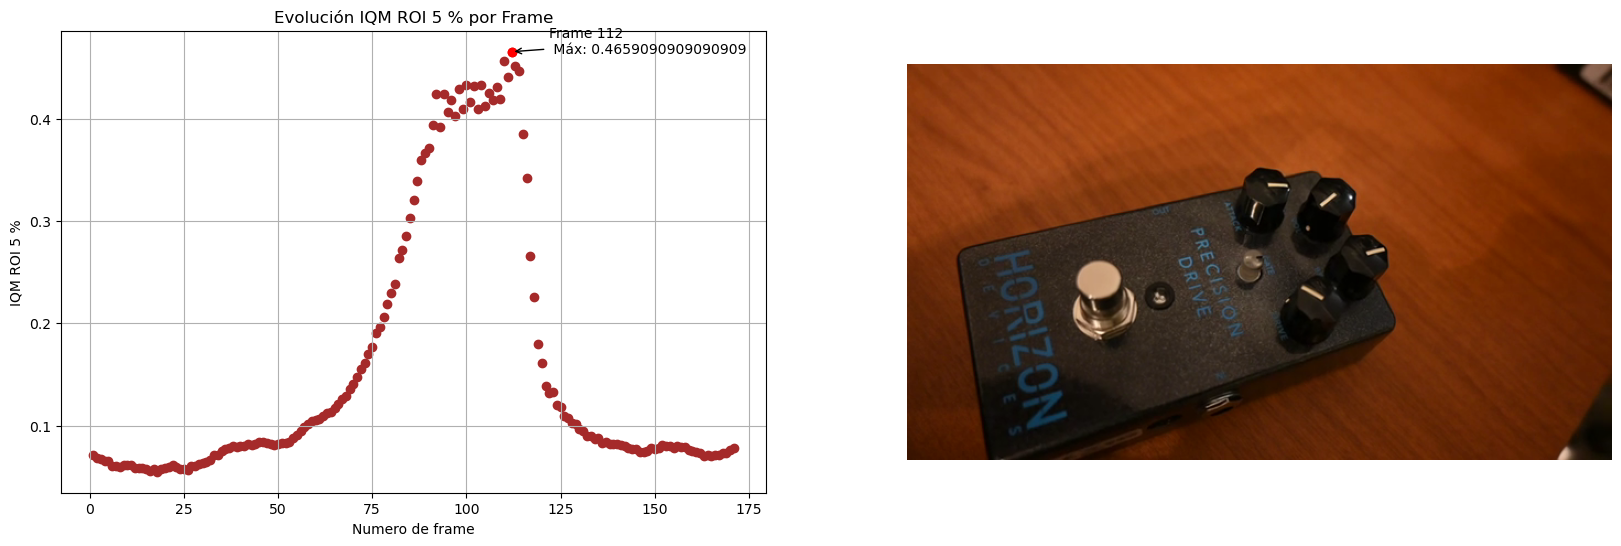

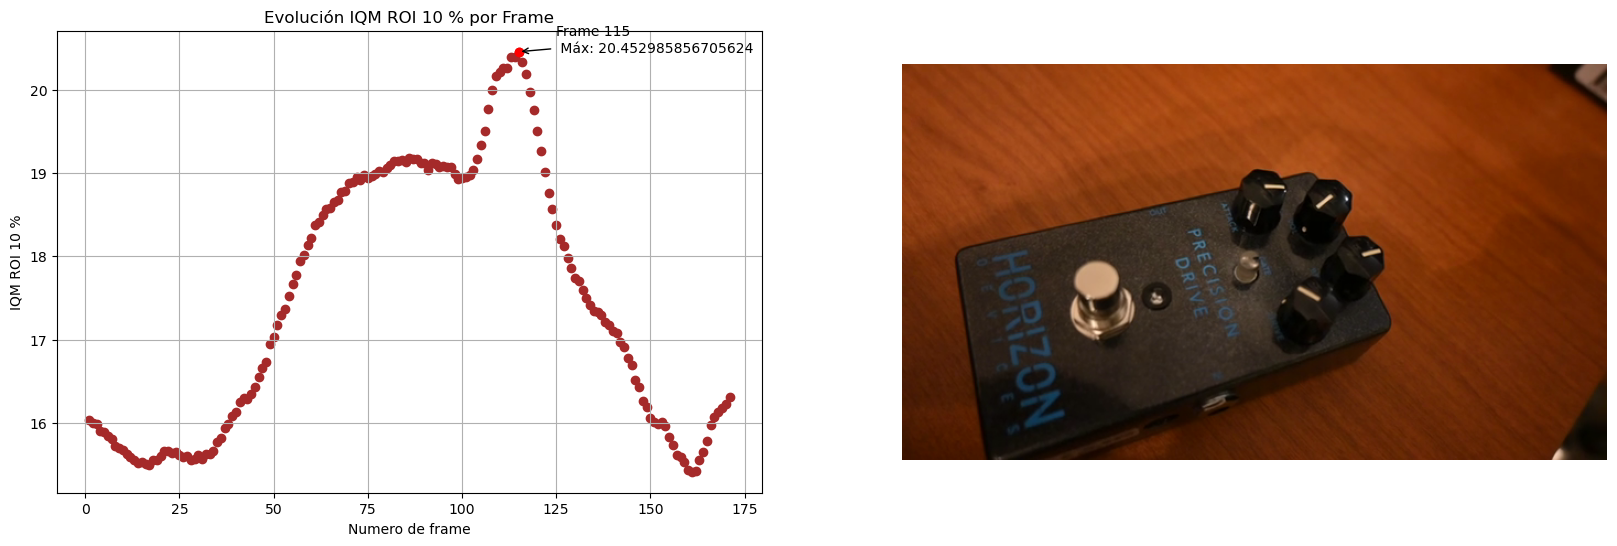

In [53]:
iqm_5_roi_frame_list = procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM ROI 5 %', roi_number=0.05)
iqm_10_roi_frame_list = procesar_video_roi(video_player, metric=calcular_acm, name_metric='IQM ROI 10 %', roi_number=0.1)

#### 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

In [54]:
def procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=1, height=1, width=1, nrows=3, ncols=3):
    video_player.unset_roi()
    video_player.restart()
    metric_lista = []

    video_player.set_matrix(height=height, width=width, nrows=nrows, ncols=ncols)
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle
            
        box_list = video_player.get_matrix_frames()
        
        # Calcular IQM sacando el promedio de las mediciones obtenidas en cada unos de los rectángulos de la matriz
        value_metric = [metric(box) for box in box_list]
        mean_metric = np.mean(value_metric)
        metric_lista.append(mean_metric)
    
    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    
    max_frame = video_player.get_frame_by_index(max_metric_frame)

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficar los resultados
    graficar_con_frame(frame_indices, metric_lista, y_label=name_metric, frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

Frame de máximo IQM MATRIX 4 X 4 110 (0.9160937499999999


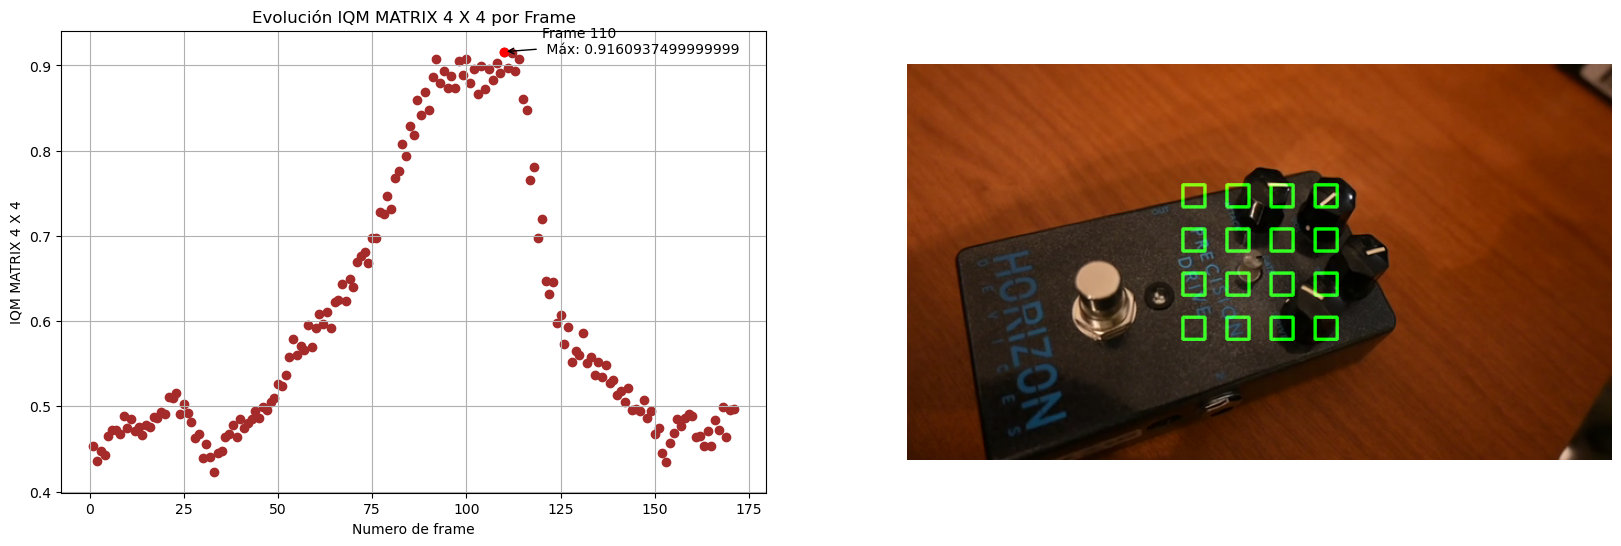

Frame de máximo IQM MATRIX 7 X 5 92 (0.9575714285714286


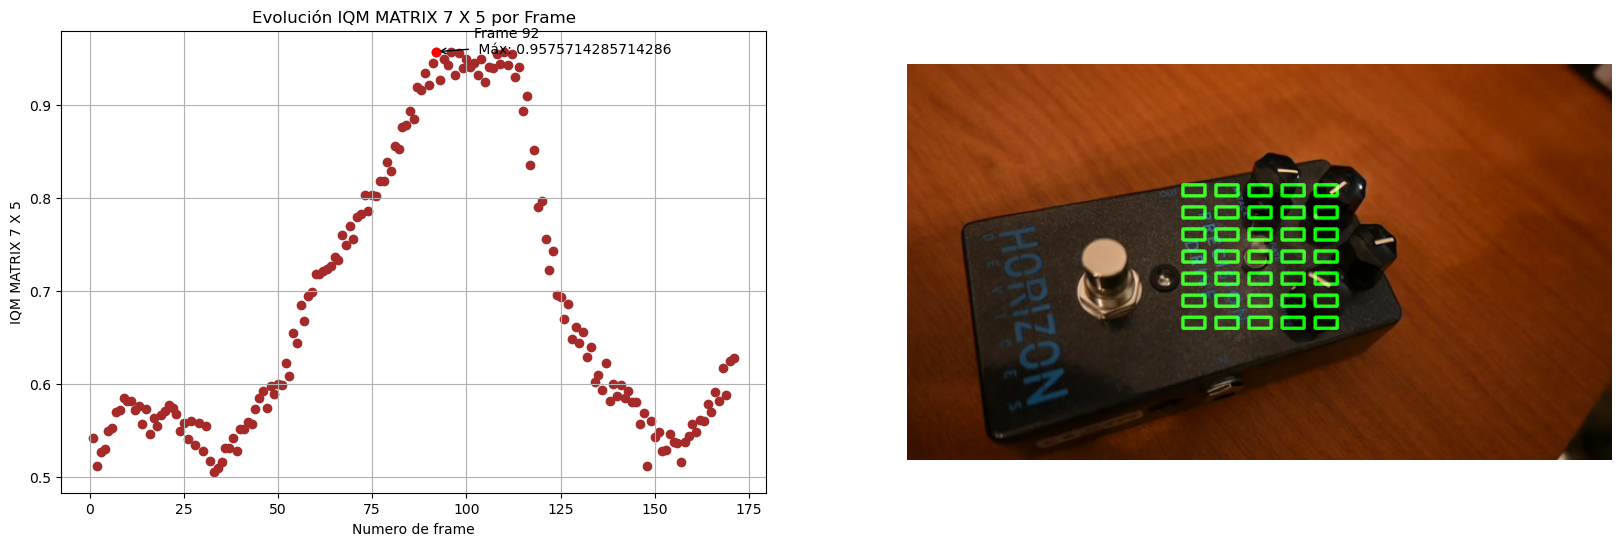

In [55]:
iqm_matrix_4x4_frame_list = procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM MATRIX 4 X 4',
                                           height=140, width=140, nrows=4, ncols=4)
iqm_matrix_7x5_frame_list = procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM MATRIX 7 X 5',
                                           height=140, width=140, nrows=7, ncols=5)

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

    EXPERIMENTO 1

In [13]:
matplotlib.use('Agg')
# Abre el video

video_player.restart()
video_player.set_roi(roi=0.2, matrix=True, nrows=5, ncols=5)

fm_score_list = list()

delay = int(600 / video_player.fps)

while True:
    frame = video_player.get_frame()
    if frame is None:
        break

    # Obtenemos la medicion    
    fm_score_list.append(calcular_iqm(video_player.get_roi_frame()))

    # Combina el frame original y la gráfica de la medicion del blur
    img_frame = convert_to_img(fm_score_list, video_player.shape, video_player.frame_count)
    frame_combined = np.hstack((frame, img_frame))
    # Mostrar el frame combinado
    cv2.imshow('Video', frame_combined)

    # Salir del loop si se presiona la tecla 'q'
    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

# Libera el objeto de captura de video y cierra todas las ventanas
cv2.waitKey(0)
cv2.destroyAllWindows()
%matplotlib inline

In [14]:
video_player.get_video_pos()

171.0

In [16]:
def procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM'):
    video_player.restart()
    metric_lista = []
    frame_numeros = []

    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle        
        # Calcular IQM
        metric_lista.append(metric(video_player.get_roi_frame()))

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1

    print(f'Frame de máximo {name_metric} {max_metric_frame} ({max(metric_lista)}')
    frame_indices = list(range(1, video_player.frame_count + 1))

    # Graficar los resultados
    graficar(frame_indices, metric_lista, y_label=name_metric)

Frame de máximo IQM 110 (0.4935980902777778


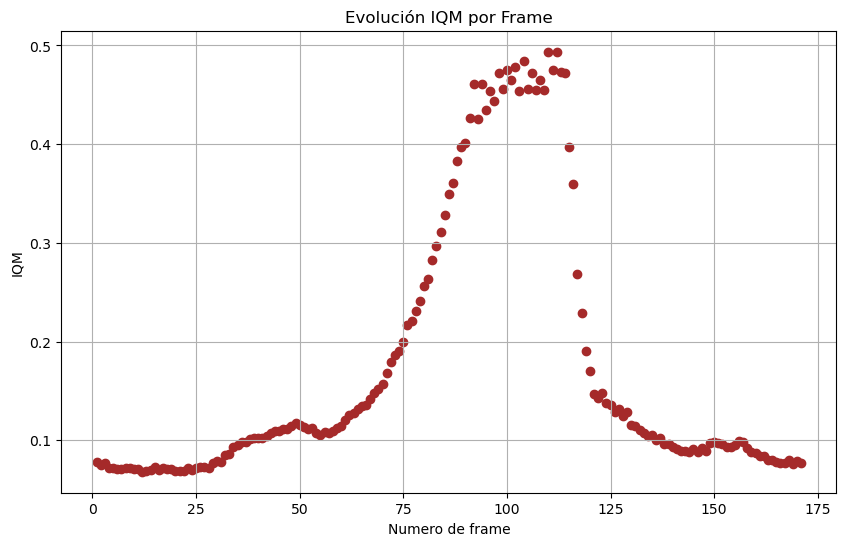

Frame de máximo ACM 113 (19.469030097678857


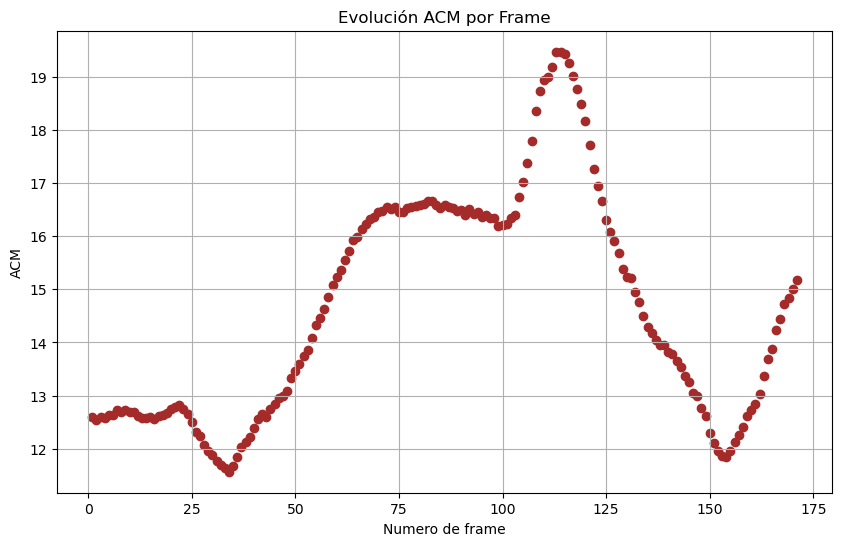

In [17]:
procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_player, metric=calcular_acm, name_metric='ACM')

Frame de maximo IQM 110 (0.028624131944444443)


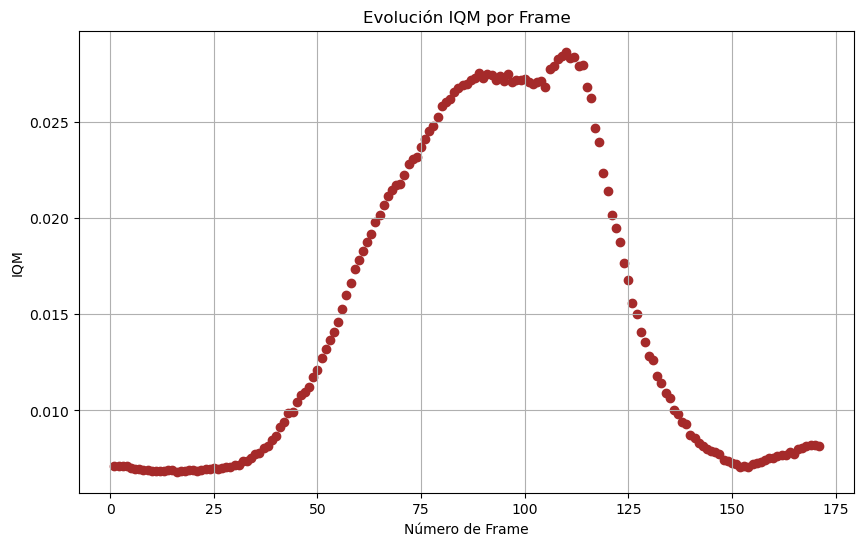

Frame de maximo ACM 118 (21.047174239321112)


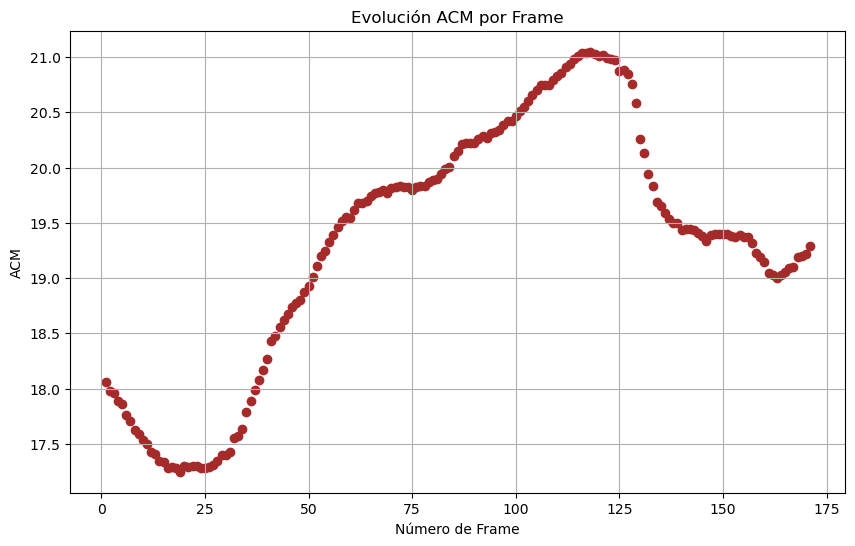

In [18]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()


procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_path, metric=calcular_acm, name_metric='ACM')

Frame de maximo IQM 110 (0.028624131944444443)


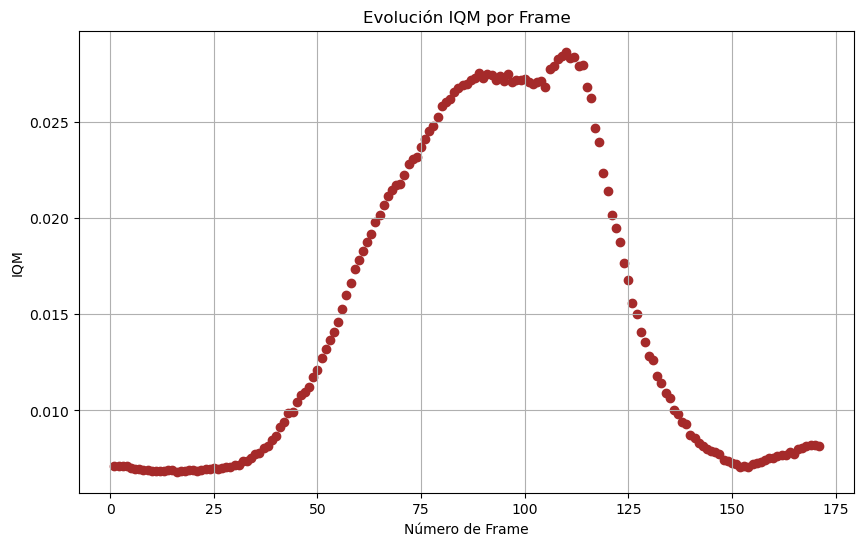

Frame de maximo ACM 118 (21.047174239321112)


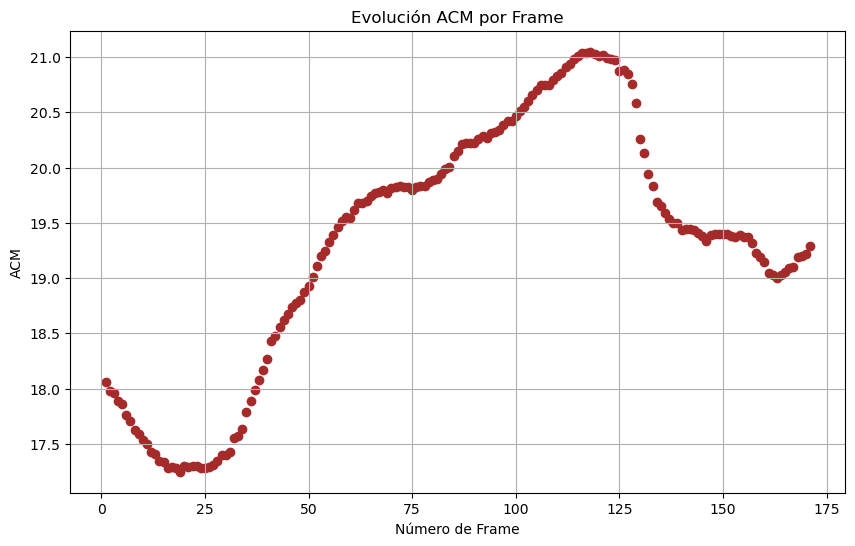

In [14]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()


procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM')
procesar_video_completo(video_path, metric=calcular_acm, name_metric='ACM')

EXPERIMENTO 2

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.87 μs
Frame de máximo IQM 112 (0.4635339330945934


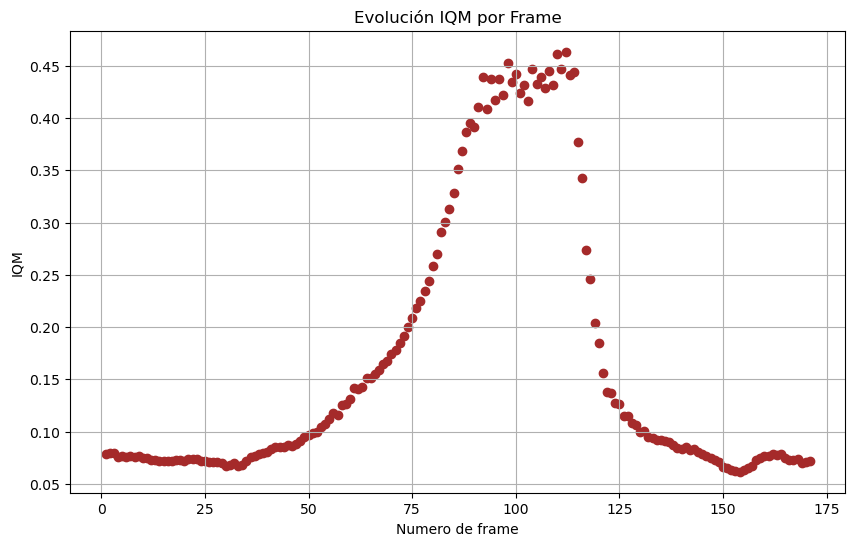

In [75]:
%time
video_player.set_roi(height=107, width=107)
procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
# procesar_video_completo(video_player,metric=calcular_acm, name_metric = 'ACM')
video_player.unset_roi()

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs
Frame de maximo IQM 112 (0.4635339330945934)


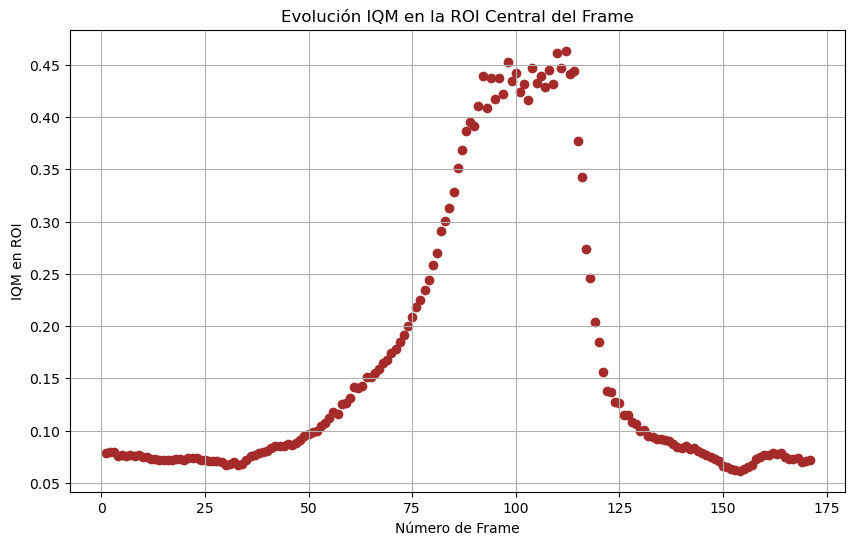

In [76]:
%time

def procesar_video_roi(video_path, porc_roi=0.05, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)
    metric_list = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        # Obtener dimensiones del frame  
        height, width = frame.shape[:2]

        # Calcular el área total del frame  
        area_total = height * width

        # Calcular el área de la ROI en base al porcentaje  
        area_roi = area_total * porc_roi

        # Determinar la longitud y ancho de la ROI  
        roi_side = int((area_roi) ** 0.5)  # Lado de la ROI cuadrada (para simplicidad)  

        # Asegurarse de que la ROI no exceda los límites del frame  
        roi_side = min(roi_side, height, width)
        # Calcular las coordenadas de la ROI centrada  
        start_x = (width - roi_side) // 2
        start_y = (height - roi_side) // 2

        # Definir la ROI  
        roi = frame[start_y:start_y + roi_side, start_x:start_x + roi_side]

        # Convertir la ROI a escala de grises
        roi_gris = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Calcular IQM para la ROI
        value_metric = metric(roi_gris)
        metric_list.append(value_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if value_metric >= max(metric_list):
            max_metric_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max(metric_list)})')

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    frame_number = 0
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_number += 1

        # Verificamos si el número de frames coincide con el fotograma de la métrica máxima  
        if frame_number == max_metric_frame:
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 255, 0),
                          2)  # Marco con verde el frame con métrica máxima  
        else:
            cv2.rectangle(frame, (start_x, start_y), (start_x + roi_side, start_y + roi_side), (0, 0, 255),
                          2)  # Marco con rojo el resto de los frames  

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_list, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_roi(video_path, porc_roi=0.05, metric=calcular_iqm, name_metric='IQM')
#procesar_video_roi(video_path, porc_roi=0.05,metric = calcular_acm, name_metric = 'ACM')

EXPERIMENTO 3

In [34]:
def procesar_video_focus_matrix(video_path, margin=10, range_X=3, range_Y=3, metric=calcular_iqm, name_metric='IQM'):
    captura_video = cv2.VideoCapture(video_path)

    metric_frame = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primer bucle para calcular los IQM y el máximo IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        height, width = frame.shape[:2]

        total_width = range_X * margin + (range_X - 1) * margin
        total_height = range_Y * margin + (range_Y - 1) * margin
        print(total_width)
        print(total_height)
        if total_width > width or total_height > height:
            print("El margen es demasiado grande para el tamaño del frame.")
            return [], frame  # Devolver la imagen sin modificaciones  

        start_x = (width - total_width) // 2
        start_y = (height - total_height) // 2

        rois = []  # Lista para almacenar los ROIs  

        for i in range(range_Y):
            for j in range(range_X):
                start_point = (start_x + j * (margin * 2),
                               start_y + i * (margin * 2))

                end_point = (start_point[0] + margin,
                             start_point[1] + margin)

                roi = frame[start_point[1]:end_point[1], start_point[0]:end_point[0]]
                rois.append((roi, (start_point, end_point)))

                # Convertir la ROI a escala de grises
        roi_gris = [cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) for roi, _ in rois]
        value_metric = [metric(roi).item() for roi in roi_gris]
        mean_metric = np.mean(value_metric).item()

        metric_frame.append(mean_metric)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    df_metric_values = pd.DataFrame({'frame': frame_numeros, 'metric': metric_frame})
    max_metric_frame = df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()]['frame'].item()
    max_metric_value = df_metric_values[df_metric_values.metric == df_metric_values.metric.max().item()][
        'metric'].item()

    print(f'Frame de maximo {name_metric} {max_metric_frame} ({max_metric_value})')

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    frame_number = 0
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_number += 1

        for roi, (start_point, end_point) in rois:
            if frame_number == max_metric_frame:
                cv2.rectangle(frame, start_point, end_point, (0, 255, 0), 2)
            else:
                cv2.rectangle(frame, start_point, end_point, (0, 0, 255), 2)

                # Mostrar el fotograma en una ventana  
        cv2.imshow('Video con ROI', frame)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, metric_frame, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} en ROI')
    plt.title(f'Evolución {name_metric} en la ROI Central del Frame')
    plt.grid(True)
    plt.show()


procesar_video_focus_matrix(video_path, margin=10, range_X=3, range_Y=3, metric=calcular_iqm, name_metric='IQM')

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
5

AttributeError: 'float' object has no attribute 'item'

In [35]:
procesar_video_focus_matrix(video_path, margin=10, range_X=7, range_Y=5, metric=calcular_acm, name_metric='ACM')

130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90
130
90

AttributeError: 'float' object has no attribute 'item'

Frame de maximo ACM 114 (9.364331428571429)


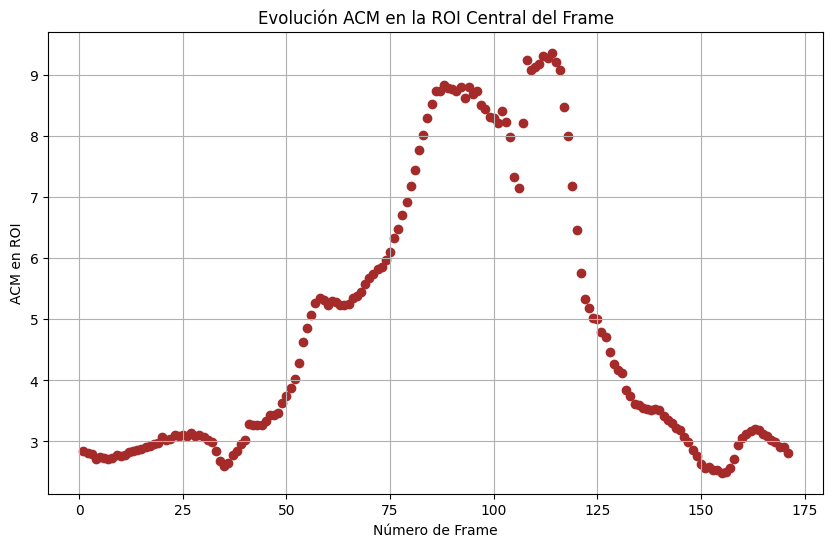

In [41]:
procesar_video_focus_matrix(video_path, margin=10, range_X=7, range_Y=5, metric=calcular_acm, name_metric='ACM')

### BONUS

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

In [25]:
def unsharp_masking(image, sigma=1.0, k=1.5):
    # Aplicar un filtro Gaussiano para obtener la imagen desenfocada
    gauss = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calcular la imagen de la máscara de enfoque (imagen original - imagen desenfocada)
    sharpened = cv2.addWeighted(image, k + 1.0, gauss, -k, 0)

    # Asegurarse de que los valores estén en el rango de 0 a 255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


In [30]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        if activate_um == True:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris, sigma=sigma_um, k=k_um)
        else:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        if activate_um == True:
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

Frame de maximo IQM 110 (0.027842881944444446)


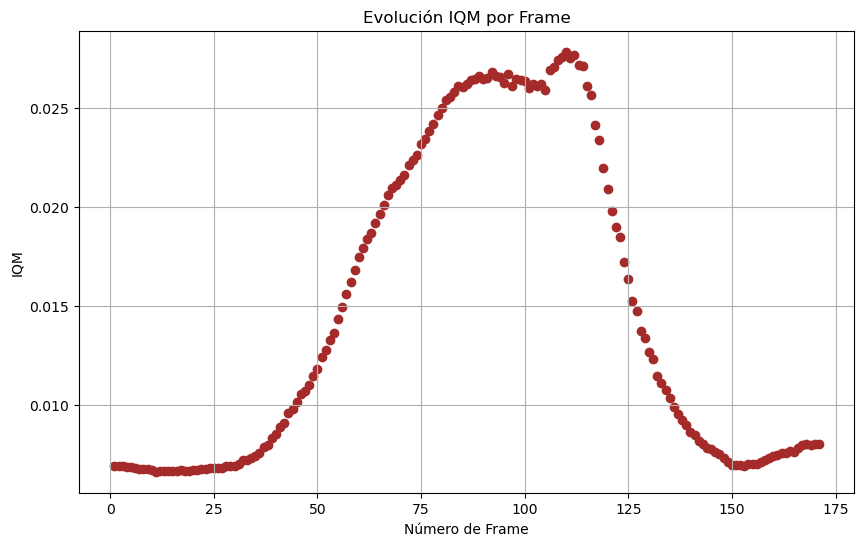

In [28]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1)

Frame de maximo IQM 112 (0.0401171875)


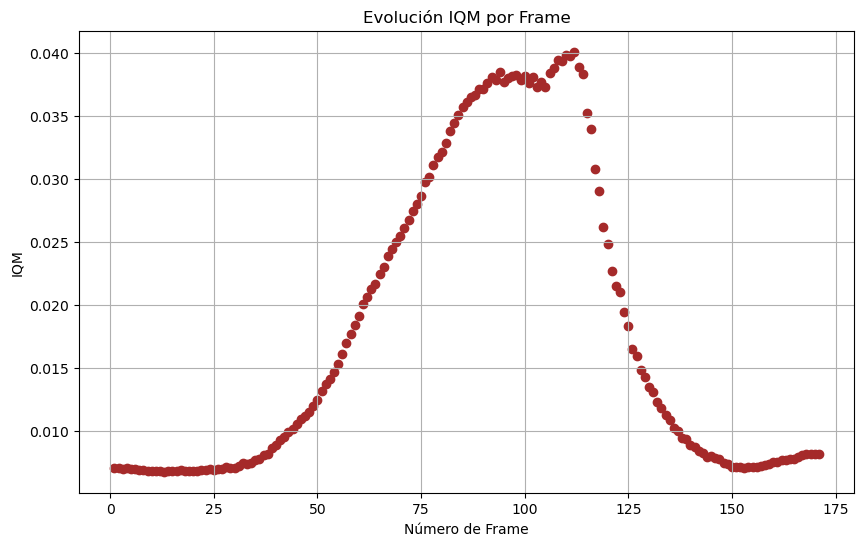

In [31]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1)

Frame de maximo IQM 92 (0.3606727430555556)


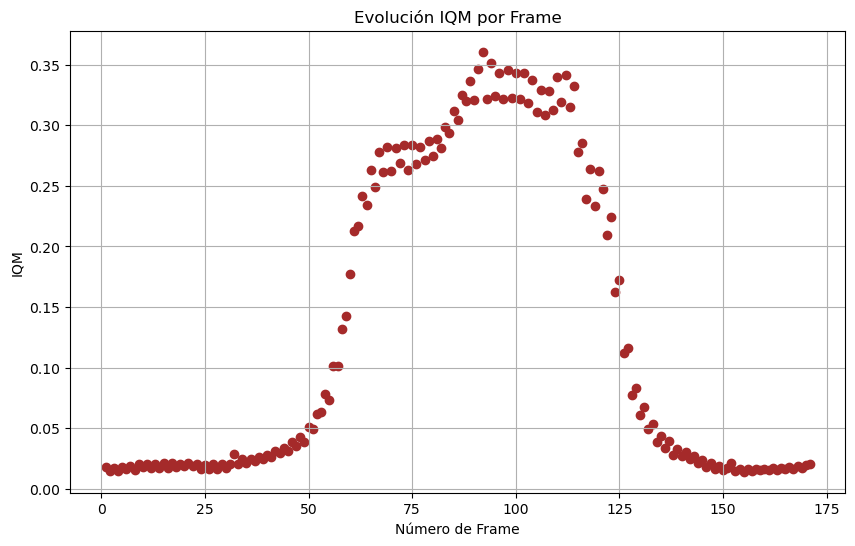

In [32]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20)

APLICANDO EN UNSHARP MASKING SOLO A LOS FRAMES QUE ESTAN ENTRE EL P40 Y P60 DE LA DISTRIBUCION --> aqui lo que sucede es que cuando ponemos un K muy grande, terminamos rompiendo la distribución del IQM

In [33]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5, p_min=40, p_max=60):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primera pasada para calcular los IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    captura_video.release()

    # Calcular los percentiles
    iqm_array = np.array(iqm_lista)
    p25, p75 = np.percentile(iqm_array, p_min), np.percentile(iqm_array, p_max)

    # Volver a capturar el video
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    max_iqm_frame = -1
    max_iqm_value = -1
    iqm_final_lista = []  # Lista para IQM combinada

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        iqm = metric(frame_gris)

        # Aplicar unsharp masking solo si IQM está entre los percentiles definidos
        if activate_um and (p25 <= iqm <= p75):
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Calcular IQM para el frame procesado (ya sea con o sin unsharp masking)
        iqm_final = metric(cv2.cvtColor(frame_um, cv2.COLOR_BGR2GRAY))
        iqm_final_lista.append(iqm_final)

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Actualizar el frame de máximo IQM
        if iqm_final > max_iqm_value:
            max_iqm_value = iqm_final
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_final_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} Final')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

    print(f'Frame de máximo {name_metric}: {max_iqm_frame} ({max_iqm_value})')

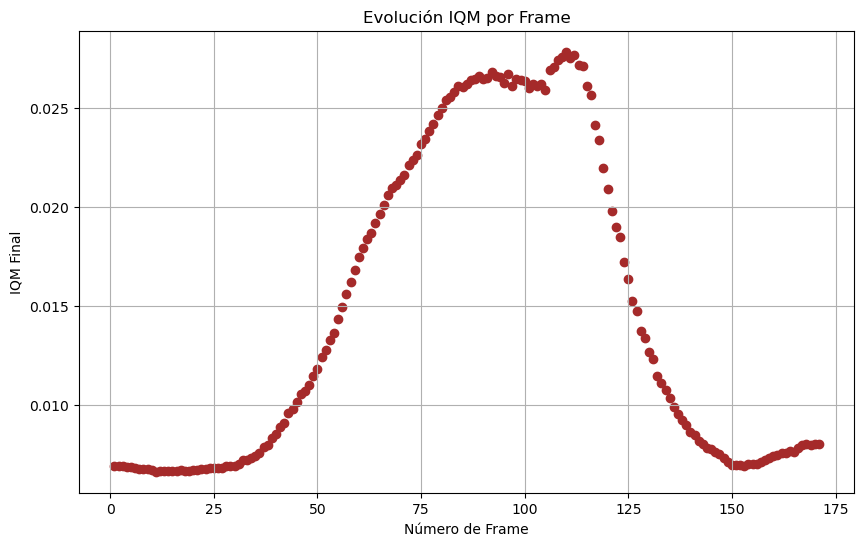

Frame de máximo IQM: 110 (0.027842881944444446)


In [34]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1,
                        p_min=25, p_max=75)

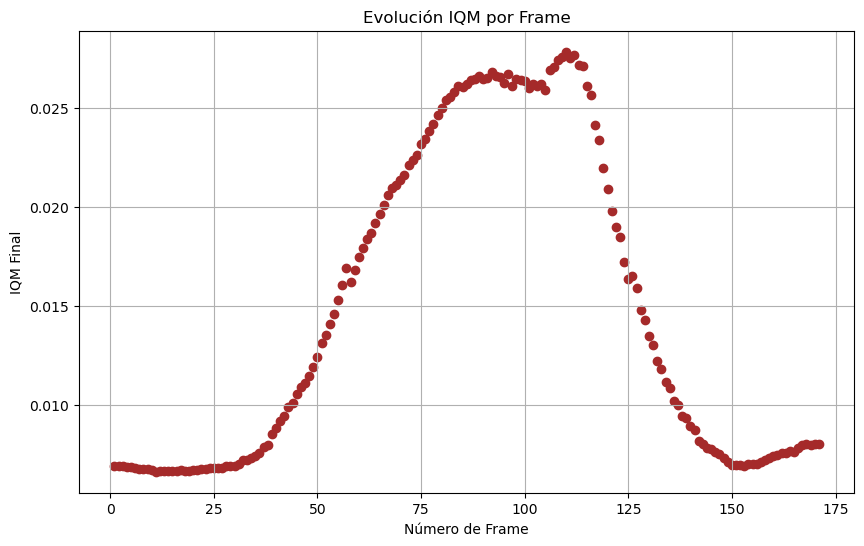

Frame de máximo IQM: 110 (0.027842881944444446)


In [35]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1,
                        p_min=40, p_max=60)

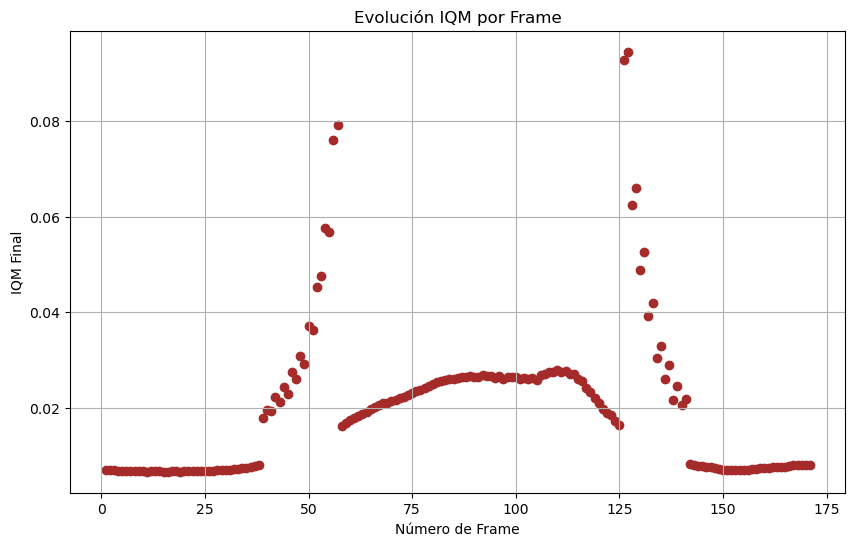

Frame de máximo IQM: 127 (0.09447916666666667)


In [36]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20,
                        p_min=40, p_max=60)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)